### Playing atari with advantage actor-critic

This time we're going to learn something harder then CartPole :)

Gym atari games only allow raw image pixels as observation, hence demanding a more powerful agent network to find meaningful features. We shall use a convolutional neural network for such task.

Most of the code in this notebook is written for you, however you are _strongly encouraged to experiment with it_ to find better agent configuration and/or learning algorithm.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#setup theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=gpu,floatX=float32

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed (apt-get install xvfb, see gym readme on xvfb)
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


# Processing game image

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape
* Converting to grayscale
* Cropping irrelevant image parts

In [ ]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from scipy.misc import imresize

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        
        <Your code here>        
        return <...>


[2017-03-29 01:18:10,194] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX 1080 (CNMeM is enabled with initial size: 22.0% of memory, cuDNN 5110)
[2017-03-29 01:18:21,072] Making new env: KungFuMaster-v0


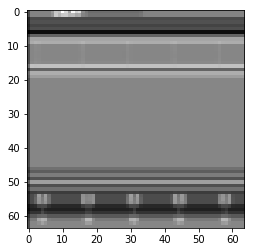

In [4]:
import gym
#game maker consider https://gym.openai.com/envs
def make_env():
    env = gym.make("KungFuMaster-v0")
    return PreprocessAtari(env)




#spawn game instance
env = make_env()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

plt.imshow(obs[0],interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into policy using simple convolutional neural network.

In [5]:
import theano, lasagne
import theano.tensor as T
from lasagne.layers import *
from agentnet.memory import WindowAugmentation

In [6]:
#observation goes here
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
prev_wnd = InputLayer((None,4)+observation_shape,name='window from last tick')
new_wnd = WindowAugmentation(observation_layer,prev_wnd,name='updated window')
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


#### Network body

Here will need to build a convolutional network that consists of 4 layers:
* 3 convolutional layers with 32 filters, 5x5 window size, 2x2 stride
 * Choose any nonlinearity but for softmax
 * You may want to increase number of filters for the last layer
* Dense layer on top of all convolutions
 * anywhere between 100 and 512 neurons

You may find a template for such network below

In [9]:
from lasagne.nonlinearities import rectify,elu,tanh,softmax

#network body
conv0 = Conv2DLayer(wnd_reshape,<...>)
conv1 = <another convolutional layer, growing from conv0>
conv2 = <yet another layer...>
        
dense = DenseLayer(<what is it's input?>,
                   nonlinearity=tanh,
                   name='dense "neck" layer')

### Network head

You will now need to build output layers.
Since we're building advantage actor-critic algorithm, out network will require two outputs:
* policy, $pi(a|s)$, defining action probabilities
* state value, $V(s)$, defining expected reward from the given state

Both those layers will grow from final dense layer from the network body.

In [11]:
#actor head
logits_layer = DenseLayer(dense,n_actions,nonlinearity=None) 
#^^^ separately define pre-softmax policy logits to regularize them later
policy_layer = NonlinearityLayer(logits_layer,softmax)

#critic head
V_layer = DenseLayer(dense,1,nonlinearity=None)

#sample actions proportionally to policy_layer
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer)



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [13]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(logits_layer,V_layer),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [14]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params([V_layer,policy_layer],trainable=True)
weights

[W,
 b,
 W,
 b,
 W,
 b,
 dense.W,
 dense.b,
 lstm.b_to_ingate,
 lstm.W_ctrl0_to_ingate,
 lstm.W_dense_to_ingate,
 lstm.b_to_forgetgate,
 lstm.W_ctrl0_to_forgetgate,
 lstm.W_dense_to_forgetgate,
 lstm.b_to_cell,
 lstm.W_ctrl0_to_cell,
 lstm.W_dense_to_cell,
 lstm.b_to_outgate,
 lstm.W_ctrl0_to_outgate,
 lstm.W_dense_to_outgate,
 lstm.W_cell_to_ingate_peephole.scales,
 lstm.W_cell_to_forgetgate_peephole.scales,
 lstm.W_cell_to_outgate_peephole.scales,
 W,
 b,
 W,
 b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [15]:
from agentnet.experiments.openai_gym.pool import EnvPool

#number of parallel agents 
N_AGENTS = 10

pool = EnvPool(agent,make_env, N_AGENTS) #may need to adjust


[2017-03-29 01:18:50,684] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,721] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,755] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,790] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,825] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,859] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,900] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,939] Making new env: KungFuMaster-v0
[2017-03-29 01:18:50,978] Making new env: KungFuMaster-v0
[2017-03-29 01:18:51,017] Making new env: KungFuMaster-v0


In [16]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(10)

print('actions:')
print(action_log[0])
print("rewards")
print(reward_log[0])

actions:
[10  1  5 12  8  1  6  0  5 12]
rewards
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
CPU times: user 261 ms, sys: 16.1 ms, total: 277 ms
Wall time: 275 ms


In [17]:
# batch sequence length (frames) 
SEQ_LENGTH = 25

#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Advantage actor-critic

* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards, alive indicators, etc.
* Code mostly copied from [here](https://github.com/yandexdataschool/tinyverse/blob/0b359aa6a5a9f666d2fa9eab97669c7930b7acb3/atari.py)

In [18]:
#get agent's Qvalues obtained via experience replay
#we don't unroll scan here and propagate automatic updates
#to speed up compilation at a cost of runtime speed
replay = pool.experience_replay

_,_,_,_,(logits_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
    unroll_scan=False,
)

auto_updates = agent.get_automatic_updates()


In [19]:

# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev
logits_flat = logits_seq.reshape([-1,logits_seq.shape[-1]])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)
        
# get policy gradient
from agentnet.learning import a2c
elwise_actor_loss,elwise_critic_loss = a2c.get_elementwise_objective(policy=logpolicy_seq,
                                                                     treat_policy_as_logpolicy=True,
                                                                     state_values=V_seq[:,:,0],
                                                                     actions=replay.actions[0],
                                                                     rewards=replay.rewards/100.,
                                                                     is_alive=replay.is_alive,
                                                                     gamma_or_gammas=0.99,
                                                                     n_steps=None,
                                                                     return_separate=True)
        
# (you can change them more or less harmlessly, this usually just makes learning faster/slower)
# also regularize to prioritize exploration
reg_logits = T.mean(logits_seq**2)
reg_entropy = T.mean(T.sum(policy_seq*logpolicy_seq,axis=-1))

#add-up loss components with magic numbers 
loss = 0.1*elwise_actor_loss.mean() +\
       0.25*elwise_critic_loss.mean() +\
       1e-3*reg_entropy +\
       1e-3*reg_logits

        


In [20]:
# Compute weight updates, clip by norm
grads = T.grad(loss,weights)
grads = lasagne.updates.total_norm_constraint(grads,10)

updates = lasagne.updates.adam(grads, weights,1e-4)

#compile train function
train_step = theano.function([],loss,updates=auto_updates+updates)

# Demo run

In [21]:
untrained_reward = np.mean(pool.evaluate(save_path="./records",
                                         record_video=True))

[2017-03-29 01:21:00,533] Making new env: KungFuMaster-v0
[2017-03-29 01:21:00,584] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-29 01:21:00,601] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.0.17080.video000000.mp4
[2017-03-29 01:21:05,881] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/justheuristic/agentnet/examples/records')


Episode finished after 1261 timesteps with reward=200.0


In [22]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [24]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

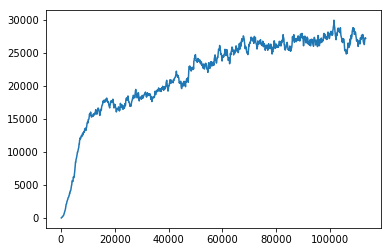

 76%|███████▌  | 113310/150000 [19:46:02<6:43:27,  1.52it/s] 

iter=113310	loss=0.349	reward/tick=7.746


 76%|███████▌  | 113320/150000 [19:46:08<6:09:25,  1.65it/s]

iter=113320	loss=0.368	reward/tick=7.778


 76%|███████▌  | 113330/150000 [19:46:14<6:19:58,  1.61it/s]

iter=113330	loss=0.371	reward/tick=7.789


 76%|███████▌  | 113331/150000 [19:46:14<6:10:44,  1.65it/s]

In [ ]:
from tqdm import trange
from IPython.display import clear_output

#the algorithm almost converges by 15k iterations, 50k is for full convergence
for i in trange(150000):    
    
    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()
    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
                                                      loss,
                                                      reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda (t,r):t)))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [ ]:
from agentnet.utils.persistence import save
save(action_layer,"kung_fu.pcl")

In [ ]:
###LOAD FROM HERE
from agentnet.utils.persistence import load
load(action_layer,"kung_fu.pcl")

In [25]:
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-03-29 01:21:33,678] Making new env: KungFuMaster-v0
[2017-03-29 01:21:33,717] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-03-29 01:21:33,734] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.1.17080.video000000.mp4
[2017-03-29 01:21:49,589] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.1.17080.video000001.mp4


Episode finished after 3493 timesteps with reward=25700.0
Episode finished after 4170 timesteps with reward=31900.0
Episode finished after 5181 timesteps with reward=41700.0
Episode finished after 4192 timesteps with reward=30200.0
Episode finished after 3440 timesteps with reward=26100.0
Episode finished after 2991 timesteps with reward=23500.0
Episode finished after 3702 timesteps with reward=29600.0


[2017-03-29 01:23:28,925] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.1.17080.video000008.mp4


Episode finished after 3242 timesteps with reward=24000.0
Episode finished after 2358 timesteps with reward=18800.0
Episode finished after 3979 timesteps with reward=29700.0
Episode finished after 5510 timesteps with reward=39800.0
Episode finished after 5083 timesteps with reward=43400.0
Episode finished after 4671 timesteps with reward=42600.0
Episode finished after 2915 timesteps with reward=26100.0
Episode finished after 4510 timesteps with reward=36600.0
Episode finished after 3877 timesteps with reward=36100.0
Episode finished after 4209 timesteps with reward=35700.0
Episode finished after 3996 timesteps with reward=31200.0
Episode finished after 3774 timesteps with reward=29400.0


[2017-03-29 01:26:12,525] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/justheuristic/agentnet/examples/records')


Episode finished after 4939 timesteps with reward=41600.0
mean session score=32185.000000.5


In [27]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## How to enhance
* More parallel agents
* Different constructs for recurrent memory
* Try PGQ-like algorithms
* Maybe tune parameters for regularization